In [1]:
%pylab inline
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
from tardis import *
from scipy import sparse,ndimage,interpolate
import corner
from mpl_toolkits.mplot3d import Axes3D
from multiprocessing import Pool
from functools import partial

Populating the interactive namespace from numpy and matplotlib
Tensorflow Version:  1.15.0


Using TensorFlow backend.


Running TARDIS 2.1...


In [2]:
!nvidia-smi

Sun Oct 18 20:39:05 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100S-PCI...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   30C    P0    35W / 250W |     12MiB / 32510MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100S-PCI...  Off  | 00000000:D8:00.0 Off |                    0 |
| N/A   29C    P0    34W / 250W |     12MiB / 32510MiB |      3%      Default |
+-------------------------------+----------------------+----------------------+
        

In [3]:
class load_universe:

    def __init__(self, tau,nc,bs):

        self.final_tau_RSD = tau
        self.nc = nc
        self.bs = bs
class load_lya():
    def __init__(self,flux_obs,skewers_fin,inverse_covar):
        self.vals_observed = flux_obs
        self.skewers_fin = skewers_fin
        self.inverse_covar = tf.SparseTensorValue(inverse_covar[0],inverse_covar[1],inverse_covar[2])

In [4]:
tau_true = load('tau_128.npy')
flux_true = exp(-tau_true)[0]
skewers_fin = np.load('hydro128/skewers_fin.npy')
flux_obs = np.load('hydro128/flux_obs.npy')
inverse_covar = np.load('hydro128/inverse_covar.npy',allow_pickle=True)
uni_final_tau_RSD = np.load('hydro128/uni_final_tau_RSD.npy')
flux_contrast = flux_obs/flux_obs.mean()-1
uni = load_universe(tau=tau_true,nc=128,bs=128)
mock_lya = load_lya(flux_obs,skewers_fin,inverse_covar)

<d_los>=0.730 Mpc/h


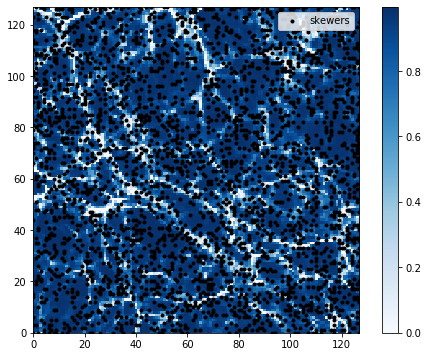

In [6]:
n_los = 3000
n = 128
figure(figsize=(8,6))
mock_lya = lya_survey(uni,2,10,sm=0.5,n_skewers=n_los)
mock_lya.select_skewers()
imshow(np.exp(-1*uni.final_tau_RSD[0,:,:,0]),cmap="Blues")
colorbar()
scatter(mock_lya.skewers_fin[::n][:,1],mock_lya.skewers_fin[::n][:,0],color='k',marker='.',label='skewers')
legend(loc=1)
ylim(0,127)
xlim(0,127)
print('<d_los>=%.3f Mpc/h'%(40/n_los**0.5))

In [8]:
def chi(inputs, data, inverse_covar):

    residual = tf.subtract(inputs, data)
    a = tf.sparse.sparse_dense_matmul(inverse_covar, residual,adjoint_b=True)
    value = tf.matmul(residual,a)
    return value

def overone(flux):

    flux = K.clip(flux,1,None)
    return(tf.reduce_sum(flux))

def nodes(flux):

    flux = K.clip(flux,0,0.4)
    return(tf.reduce_sum(flux))
#The final loss functon we want to minimize

tf.compat.v1.reset_default_graph()
lya = mock_lya
anneal_steps=[2.5,2,1.5,0.7]
k=[6,6,0.4,0.1]
nc = 128
bs = 128
gtol=1e-5/512
maxiter=[50,50,60,30]
kvec = fftk((nc,nc,nc), symmetric=False)
kmesh = sum((np.array(kvec,dtype=object))**2)**0.5
pkmesh = ipklin(kmesh)

initial=tf.Variable(np.zeros(shape=(1,nc,nc,nc)),dtype='float32',trainable=True)
RSD_tau = tf.multiply(initial,1)
Rs = tf.placeholder(tf.float64, shape = [1], name='smoothing')

sum_op = reduce_sum_det
Rsm = tf.multiply(Rs, 1)

flux = tf.exp(-RSD_tau)
flux_s = smoothing(flux,Rsm,kmesh,nc)
yy_lya = tf.placeholder(tf.float32, [lya.skewers_fin.shape[0]]) #lya flux
flux_val = flowpm.cic_readout(flux_s,np.array(lya.skewers_fin,dtype=np.float32).reshape(1,-1,3))
obj_fun = k[0]*(chi(flux_val,yy_lya,lya.inverse_covar)+k[1]*sum_op(tf.square(tf.subtract(flux_s,flux)))
            +k[2]*overone(flux)+k[3]*nodes(flux))

sess = tf.Session()
sess.run(tf.compat.v1.global_variables_initializer())

time_start = time.time()
for nn,r0 in enumerate(anneal_steps):
    opt = ScipyOptimizerInterface(obj_fun, var_list=[initial], method='L-BFGS-B',
                                       options={'maxiter': maxiter[nn], 'gtol':gtol,'disp': True})

    z = opt.minimize(sess, {yy_lya:lya.vals_observed,Rs:[r0]})
time_end = time.time()
print('Total run time %f'%(time_end-time_start))
recon_RSD_tau,recon_flux = sess.run([RSD_tau,flux_val],{yy_lya:lya.vals_observed,Rs:[0]})

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 8232448.000000
  Number of iterations: 38
  Number of functions evaluations: 58
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 8210557.000000
  Number of iterations: 42
  Number of functions evaluations: 58
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 8170289.000000
  Number of iterations: 60
  Number of functions evaluations: 61
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 7929635.000000
  Number of iterations: 30
  Number of functions evaluations: 33
Total run time 97.719417


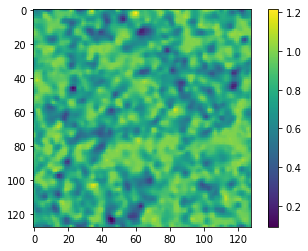

In [9]:
flux_out = exp(-recon_RSD_tau)
imshow(flux_out[0,...,0])
colorbar()

In [10]:
d_f = zeros([128,128])
t1 = time.time()
flux2_tf = tf.placeholder(tf.float32, shape = [1,128,128,128])
flux_s = smoothing(flux2_tf,Rsm,kmesh,nc)
flux_val = flowpm.cic_readout(flux_s,np.array(lya.skewers_fin,dtype=np.float32).reshape(1,-1,3))
obj_fun2 = k[0]*(chi(flux_val,yy_lya,lya.inverse_covar)+k[1]*sum_op(tf.square(tf.subtract(flux_s,flux2_tf)))
                    +k[2]*overone(flux2_tf)+k[3]*nodes(flux2_tf))
sess.run(tf.compat.v1.global_variables_initializer())
loss_0 = sess.run(obj_fun2,{yy_lya:lya.vals_observed,Rs:[0],flux2_tf:flux_out.copy()})[0][0]
for i in range(128):
    for j in range(128):
        flux2 = flux_out.copy()
        flux2[0][i,j,64] = flux2[0][i,j,64]+0.1
        a = sess.run(obj_fun2,{yy_lya:lya.vals_observed,Rs:[0],flux2_tf:flux2})
        print('\r'+str(time.time()-t1),end=' ')
        d_f[i,j]=a[0][0]
d_f = d_f-loss_0

1022.7190101146698 

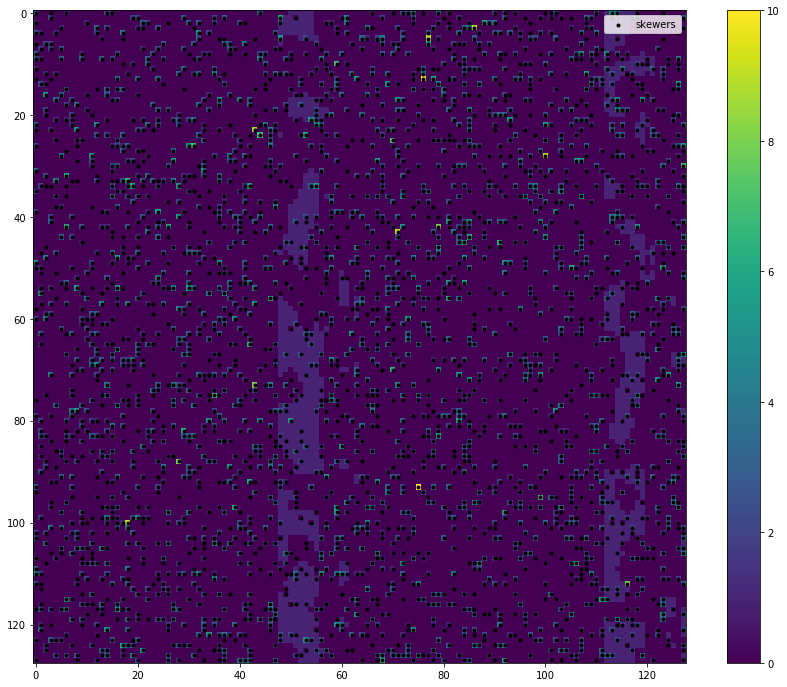

In [24]:
figure(figsize=(15,12))
imshow((abs(d_f).T))
colorbar()
plt.scatter(mock_lya.skewers_fin[::n][:,0],mock_lya.skewers_fin[::n][:,1],color='k',marker='.',label='skewers')
legend()

In [ ]:
d_f2 = zeros([128,128])
t1 = time.time()
flux2_tf = tf.placeholder(tf.float32, shape = [1,128,128,128])
flux_s = smoothing(flux2_tf,Rsm,kmesh,nc)
flux_val = flowpm.cic_readout(flux_s,np.array(lya.skewers_fin,dtype=np.float32).reshape(1,-1,3))
obj_fun2 = k[0]*(chi(flux_val,yy_lya,lya.inverse_covar)+k[1]*sum_op(tf.square(tf.subtract(flux_s,flux2_tf)))
                    +k[2]*overone(flux2_tf)+k[3]*nodes(flux2_tf))
sess.run(tf.compat.v1.global_variables_initializer())
loss_0 = sess.run(obj_fun2,{yy_lya:lya.vals_observed,Rs:[0],flux2_tf:flux_out.copy()})[0][0]
for i in range(32):
    for j in range(32):
        flux2 = flux_out.copy()
        flux2[0][i,j,80] = flux2[0][i,j,80]+0.1
        a = sess.run(obj_fun2,{yy_lya:lya.vals_observed,Rs:[0],flux2_tf:flux2})
        print('\r'+str(time.time()-t1),end=' ')
        d_f2[i,j]=a[0][0]
d_f2 = d_f2-loss_0

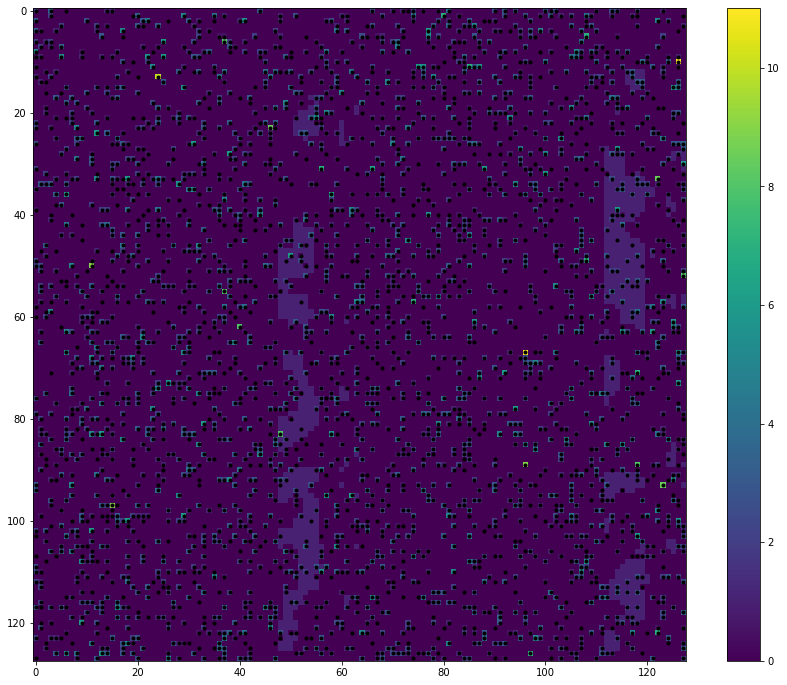

In [46]:
figure(figsize=(15,12))
imshow(abs(d_f2).T)
colorbar()
plt.scatter(mock_lya.skewers_fin[::n][:,0],mock_lya.skewers_fin[::n][:,1],color='k',marker='.',label='skewers')
show()